In [1]:
#This tutorial highlights on how to quickly build a Learner and train a model on collaborative filtering
#tasks

#Recommendation engine using collaborating filtering on Movielens

from fastai.tabular.all import *
from fastai.collab import *

In [2]:
#Training a model

#For this tutorial, we will use the Movielens 100k data dataset. We can download it easily and decompress
#it with the following function:

path = untar_data(URLs.ML_100k)

In [3]:
#The main table is in u.data. Since it's not a proper csv, we have to specify a few things while opening
#it: the tab delimiter, the columns we want to keep and their names.

ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None,
                      usecols=(0,1,2), names=['user','movie','rating'])
ratings.head()

,user,movie,rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1


In [4]:
#Movie ids are not ideal to look at things, so we load the corresponding movie id to the title that is in
#the table u.item:

movies = pd.read_csv(path/'u.item',  delimiter='|', encoding='latin-1',
                     usecols=(0,1), names=('movie','title'), header=None)
movies.head()

,movie,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [5]:
#Next we merge it to our ratings table:

ratings = ratings.merge(movies)
ratings.head()

,user,movie,rating,title
0,196,242,3,Kolya (1996)
1,63,242,3,Kolya (1996)
2,226,242,5,Kolya (1996)
3,154,242,3,Kolya (1996)
4,306,242,5,Kolya (1996)


In [6]:
#We can then build a DataLoaders object from this table. By default, it takes the first column for user,
#the second column for the item (here our movies) and the third column for the ratings. We need to change
#the value of item_name in our case, to use the titles instead of the ids:

dls = CollabDataLoaders.from_df(ratings, item_name='title', bs=64)

In [7]:
#In all applications, when the data has been assembled in a DataLoaders, you can have a look at it with 
#the show_batch method

dls.show_batch()

,user,title,rating
0,768,Primal Fear (1996),4
1,654,Raising Arizona (1987),4
2,493,Starship Troopers (1997),1
3,506,Amadeus (1984),4
4,92,Homeward Bound II: Lost in San Francisco (1996),2
5,318,"Client, The (1994)",4
6,933,"Godfather: Part II, The (1974)",4
7,717,In & Out (1997),4
8,405,Three Wishes (1995),1
9,644,Air Bud (1997),4


In [8]:
#fastai can create and train a collaborative filtering model by using collab_learner:

learn = collab_learner(dls, n_factors=50, y_range=(0, 5.5))

In [9]:
#It uses a simple dot product model with 50 latent factors. To train it using the 1cycle policy,we just
#run this command:

learn.fit_one_cycle(5, 5e-3, wd=0.1)

#Note:- Here's some benchmarks on the same dataset for the popular Librec system for collaborative 
#filtering. They show best results based on RMSE of 0.91 (scroll down to the 100k dataset), which
#corresponds to an MSE of 0.91**2 = 0.83. So in less than a minute, we got pretty good results!

epoch,train_loss,valid_loss,time
0,0.923740,0.932085,00:18
1,0.836455,0.872515,00:17
2,0.720614,0.827971,00:18
3,0.578840,0.817020,00:18
4,0.472330,0.817267,00:18


In [10]:
#Interpretation:-

#Let's analyze the results of our previous model. We will keep the 1000 most rated movies for this:

g = ratings.groupby('title')['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_movies[:10]

array(['Star Wars (1977)', 'Contact (1997)', 'Fargo (1996)',
       'Return of the Jedi (1983)', 'Liar Liar (1997)',
       'English Patient, The (1996)', 'Scream (1996)', 'Toy Story (1995)',
       'Air Force One (1997)', 'Independence Day (ID4) (1996)'],
      dtype=object)

In [11]:
#Movie bias:-

#Our model has learned one bias per movie, a unique number independent of users that can be interpreted
#as the intrinsic "value" of the movie. We can grab the bias of each movie in our top_movies list with 
#the following command:

movie_bias = learn.model.bias(top_movies, is_item=True)
movie_bias.shape

torch.Size([1000])

In [12]:
#Let's compare those biases with the average ratings:

mean_ratings = ratings.groupby('title')['rating'].mean()
movie_ratings = [(b, i, mean_ratings.loc[i]) for i,b in zip(top_movies,movie_bias)]

In [13]:
#Now let's have a look at the movies with the worst bias:

item0 = lambda o:o[0]
sorted(movie_ratings, key=item0)[:15]

[(tensor(-0.3703),
  'Children of the Corn: The Gathering (1996)',
  1.3157894736842106),
 (tensor(-0.3147),
  'Lawnmower Man 2: Beyond Cyberspace (1996)',
  1.7142857142857142),
 (tensor(-0.2804), 'Cable Guy, The (1996)', 2.339622641509434),
 (tensor(-0.2781), 'Home Alone 3 (1997)', 1.894736842105263),
 (tensor(-0.2629), 'Free Willy 3: The Rescue (1997)', 1.7407407407407407),
 (tensor(-0.2550), 'Crow: City of Angels, The (1996)', 1.9487179487179487),
 (tensor(-0.2506), 'Leave It to Beaver (1997)', 1.8409090909090908),
 (tensor(-0.2486), 'Super Mario Bros. (1993)', 2.076923076923077),
 (tensor(-0.2358), 'Mortal Kombat: Annihilation (1997)', 1.9534883720930232),
 (tensor(-0.2272), 'Barb Wire (1996)', 1.9333333333333333),
 (tensor(-0.2262), 'Airheads (1994)', 2.34375),
 (tensor(-0.2254), 'Island of Dr. Moreau, The (1996)', 2.1578947368421053),
 (tensor(-0.2068),
  'Tales from the Crypt Presents: Bordello of Blood (1996)',
  2.6363636363636362),
 (tensor(-0.2060), 'Beautician and the Beas

In [14]:
#Now let's have a look at the movies with the best bias:

sorted(movie_ratings, key=lambda o: o[0], reverse=True)[:15]

#Note:- There is certainly a strong correlation!

[(tensor(0.6094), 'Titanic (1997)', 4.2457142857142856),
 (tensor(0.5694), "Schindler's List (1993)", 4.466442953020135),
 (tensor(0.5600), 'L.A. Confidential (1997)', 4.161616161616162),
 (tensor(0.5528), 'Shawshank Redemption, The (1994)', 4.445229681978798),
 (tensor(0.5339), 'Star Wars (1977)', 4.3584905660377355),
 (tensor(0.5314), 'Apt Pupil (1998)', 4.1),
 (tensor(0.5196), 'Silence of the Lambs, The (1991)', 4.28974358974359),
 (tensor(0.5064), 'Casablanca (1942)', 4.45679012345679),
 (tensor(0.5000), 'As Good As It Gets (1997)', 4.196428571428571),
 (tensor(0.4930), 'Usual Suspects, The (1995)', 4.385767790262173),
 (tensor(0.4766), 'Rear Window (1954)', 4.3875598086124405),
 (tensor(0.4469), 'Good Will Hunting (1997)', 4.262626262626263),
 (tensor(0.4384), 'Raiders of the Lost Ark (1981)', 4.252380952380952),
 (tensor(0.4370),
  'Wallace & Gromit: The Best of Aardman Animation (1996)',
  4.447761194029851),
 (tensor(0.4276), 'Fugitive, The (1993)', 4.044642857142857)]

In [15]:
#Movie weights:

#Now let's try to analyze the latent factors our model has learned. We can grab the weights for each 
#movie in top_movies the same way as we did for the bias before.

movie_w = learn.model.weight(top_movies, is_item=True)
movie_w.shape

torch.Size([1000, 50])

In [16]:
#Let's try a PCA to reduce the dimensions and see if we can see what the model learned:

movie_pca = movie_w.pca(3)
movie_pca.shape

torch.Size([1000, 3])

In [17]:
fac0,fac1,fac2 = movie_pca.t()
movie_comp = [(f, i) for f,i in zip(fac0, top_movies)]

In [18]:
#Here are the highest score on the first dimension:

sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(1.1638), 'Wrong Trousers, The (1993)'),
 (tensor(1.1418), 'Close Shave, A (1995)'),
 (tensor(1.1152), 'Chinatown (1974)'),
 (tensor(1.0852), 'Casablanca (1942)'),
 (tensor(1.0325), 'When We Were Kings (1996)'),
 (tensor(1.0290), 'Third Man, The (1949)'),
 (tensor(1.0253),
  'Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1963)'),
 (tensor(1.0055), 'M (1931)'),
 (tensor(0.9990), 'Manchurian Candidate, The (1962)'),
 (tensor(0.9853), 'Citizen Kane (1941)')]

In [19]:
#Here are the worst scores on the first dimension:

sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-1.2535), "McHale's Navy (1997)"),
 (tensor(-1.2465), 'Home Alone 3 (1997)'),
 (tensor(-1.1998), 'Children of the Corn: The Gathering (1996)'),
 (tensor(-1.1475), 'Flipper (1996)'),
 (tensor(-1.1214), 'Grease 2 (1982)'),
 (tensor(-1.1094), 'Bio-Dome (1996)'),
 (tensor(-1.0921), 'Drop Dead Fred (1991)'),
 (tensor(-1.0886), 'Striptease (1996)'),
 (tensor(-1.0885), 'Jungle2Jungle (1997)'),
 (tensor(-1.0805), 'Super Mario Bros. (1993)')]

In [20]:
#Same thing for our second dimension:

movie_comp = [(f, i) for f,i in zip(fac1, top_movies)]

In [21]:
#Here are the highest score on the second dimension:

sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(1.0769), 'Braveheart (1995)'),
 (tensor(1.0409), 'Raiders of the Lost Ark (1981)'),
 (tensor(1.0131), 'Titanic (1997)'),
 (tensor(0.9094), 'Forrest Gump (1994)'),
 (tensor(0.8757), 'American President, The (1995)'),
 (tensor(0.8677), 'Independence Day (ID4) (1996)'),
 (tensor(0.8427), "It's a Wonderful Life (1946)"),
 (tensor(0.8226), 'Sleepless in Seattle (1993)'),
 (tensor(0.8202), 'Top Gun (1986)'),
 (tensor(0.8173), 'Hunt for Red October, The (1990)')]

In [22]:
#Here are the worst score on the second dimension:

sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-0.9090), 'Serial Mom (1994)'),
 (tensor(-0.8676), 'Nosferatu (Nosferatu, eine Symphonie des Grauens) (1922)'),
 (tensor(-0.8378), 'Trainspotting (1996)'),
 (tensor(-0.8280), 'Canadian Bacon (1994)'),
 (tensor(-0.8160), 'Road to Wellville, The (1994)'),
 (tensor(-0.8137), 'Three Colors: Blue (1993)'),
 (tensor(-0.7983), 'Brazil (1985)'),
 (tensor(-0.7845), 'Crumb (1994)'),
 (tensor(-0.7788), 'Heavenly Creatures (1994)'),
 (tensor(-0.7738), 'Jude (1996)')]

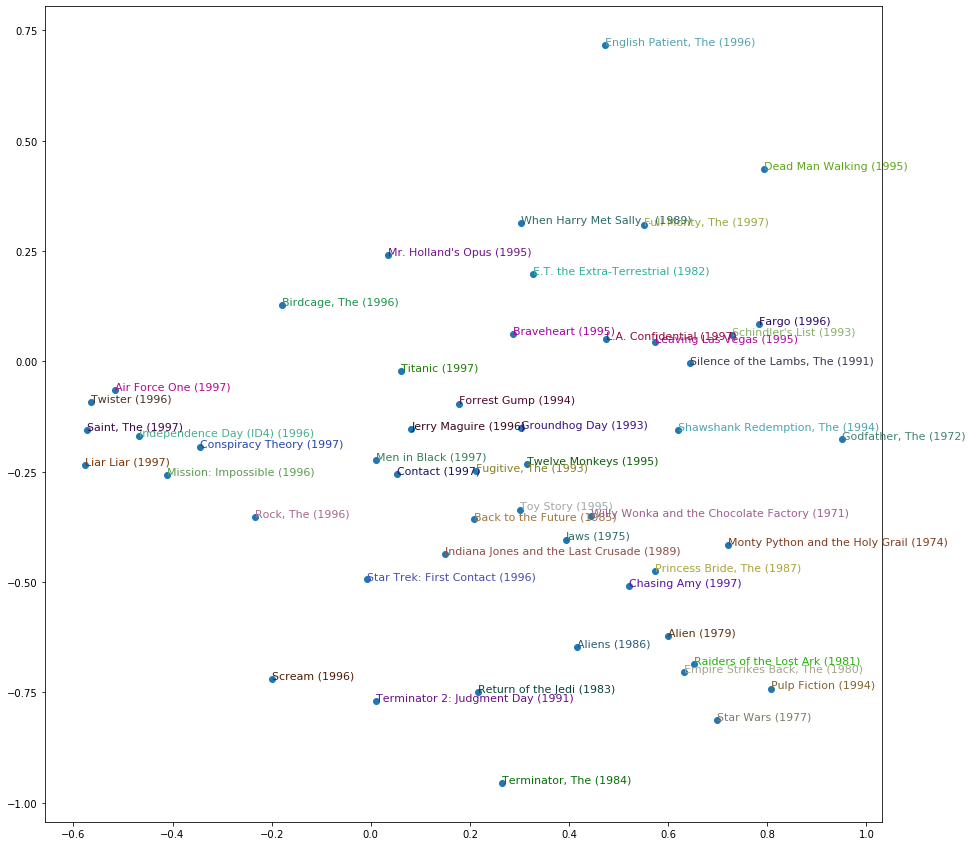

In [23]:
#And we can even plot the movies according to their scores on those dimensions:

idxs = np.random.choice(len(top_movies), 50, replace=False)
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()